# _*Qiskit Aqua: qGANs for Loading Random Distributions*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Christa Zoufal<sup>[1,2]</sup>, Stefan Woerner<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ
- <sup>[2]</sup>ETH Zurich

### Introduction
Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state: 
$$\lvert g_{\theta}\rangle = \sum\limits_{j=0}^{2^n-1}\sqrt{p_{\theta}^{j}}\lvert{j}\rangle$$
where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\vert j\rangle$. 

The aim of the qGAN training is to generate a state $\lvert g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to <a href="https://arxiv.org/abs/1904.00043">Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.</a>

In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import absolute_import, division, print_function

import numpy as np

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline


import time

start = time.time()

from torch import optim

from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution 
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.algorithms.adaptive import QGAN
from qiskit.aqua.algorithms.adaptive.qgan.discriminator import DiscriminatorNet

from qiskit.aqua import aqua_globals, QuantumInstance

from qiskit import BasicAer

/Users/ouf/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit_terra-0.8.0-py3.7-macosx-10.7-x86_64.egg/qiskit/circuit/variabletable.py:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping


### Load the Training Data
First, we need to load the $k$-dimensional training data samples (here k=1). <br/>
Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

In [2]:
# Number training data samples
N = 10000 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

### Initialize the qGAN
The qGAN consists of a quantum generator $G_{\theta}$, a variational quantum circuit, and a classical discriminator $D_{\phi}$, a neural network. <br/>
To implement the quantum generator, we choose a depth-$1$ variational form that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should $>1$ becaue the higher the circuit depth the because higher circuit depths enable the representation of more complex structures.<br/>
The classical discriminator is given by a $3$-layer neural network that applies linear transformations, leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. Notably, the neural network is implemented with PyTorch. Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.<br/>
Here, both networks are updated with the ADAM optimization algorithm.

In [3]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3000
# Batch size
batch_size = 1000

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)

# Set quantum instance to run the quantum generator
backend = BasicAer.get_backend('statevector_simulator')
qgan.set_quantum_instance(QuantumInstance(backend=backend, shots=batch_size, coupling_map=None, circuit_caching=False))


# Set entangler map
entangler_map = [[0, 1]]
        
# Set variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * 1e-2
# Set an initial state for the generator circuit
init_dist = UniformDistribution(np.sum(num_qubits), low=bounds[0], high=bounds[1])
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(sum(num_qubits), var_form, init_params,
                                        initial_distribution=init_dist, low=bounds[0], high=bounds[1])
# Set generator optimizer
g_optimizer = ADAM(maxiter=1, tol=1e-6, lr=1e-5, beta_1=0.9, beta_2=0.99, noise_factor=1e-6,
                 eps=1e-10, amsgrad=True)
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_optimizer=g_optimizer)

# Set discriminator network
d_net = DiscriminatorNet(n_features=k)
# Set discriminator optimizer
d_optimizer = optim.Adam(d_net.parameters(), lr=1e-5, amsgrad=True)
# Set classical discriminator neural network
qgan.set_discriminator(discriminator_net=d_net, discriminator_optimizer=d_optimizer)

### Run the qGAN Training
During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$
and
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

In [4]:
# Run qGAN
qgan.run()

# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

Epoch 1/3000...
Loss Discriminator:  0.6972
Loss Generator:  0.6728
Relative Entropy:  0.168
Epoch 11/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.6919
Relative Entropy:  0.1678
Epoch 21/3000...
Loss Discriminator:  0.6799
Loss Generator:  0.7046
Relative Entropy:  0.1671
Epoch 31/3000...
Loss Discriminator:  0.6759
Loss Generator:  0.7164
Relative Entropy:  0.1664
Epoch 41/3000...
Loss Discriminator:  0.6739
Loss Generator:  0.7235
Relative Entropy:  0.1657
Epoch 51/3000...
Loss Discriminator:  0.673
Loss Generator:  0.7303
Relative Entropy:  0.165
Epoch 61/3000...
Loss Discriminator:  0.6755
Loss Generator:  0.733
Relative Entropy:  0.1644
Epoch 71/3000...
Loss Discriminator:  0.669
Loss Generator:  0.7349
Relative Entropy:  0.1637
Epoch 81/3000...
Loss Discriminator:  0.6697
Loss Generator:  0.7371
Relative Entropy:  0.163
Epoch 91/3000...
Loss Discriminator:  0.6704
Loss Generator:  0.7363
Relative Entropy:  0.1623
Epoch 101/3000...
Loss Discriminator:  0.6703
Loss Genera

Epoch 861/3000...
Loss Discriminator:  0.676
Loss Generator:  0.7205
Relative Entropy:  0.1162
Epoch 871/3000...
Loss Discriminator:  0.6734
Loss Generator:  0.7186
Relative Entropy:  0.1157
Epoch 881/3000...
Loss Discriminator:  0.6779
Loss Generator:  0.7213
Relative Entropy:  0.1151
Epoch 891/3000...
Loss Discriminator:  0.6788
Loss Generator:  0.7231
Relative Entropy:  0.1146
Epoch 901/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7191
Relative Entropy:  0.1141
Epoch 911/3000...
Loss Discriminator:  0.6763
Loss Generator:  0.7193
Relative Entropy:  0.1136
Epoch 921/3000...
Loss Discriminator:  0.6749
Loss Generator:  0.7223
Relative Entropy:  0.1131
Epoch 931/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7194
Relative Entropy:  0.1125
Epoch 941/3000...
Loss Discriminator:  0.678
Loss Generator:  0.7201
Relative Entropy:  0.112
Epoch 951/3000...
Loss Discriminator:  0.6761
Loss Generator:  0.7191
Relative Entropy:  0.1115
Epoch 961/3000...
Loss Discriminator:  0.67

Epoch 1711/3000...
Loss Discriminator:  0.6799
Loss Generator:  0.7111
Relative Entropy:  0.0763
Epoch 1721/3000...
Loss Discriminator:  0.6817
Loss Generator:  0.7081
Relative Entropy:  0.0759
Epoch 1731/3000...
Loss Discriminator:  0.6831
Loss Generator:  0.7095
Relative Entropy:  0.0755
Epoch 1741/3000...
Loss Discriminator:  0.6809
Loss Generator:  0.711
Relative Entropy:  0.075
Epoch 1751/3000...
Loss Discriminator:  0.682
Loss Generator:  0.7098
Relative Entropy:  0.0746
Epoch 1761/3000...
Loss Discriminator:  0.6836
Loss Generator:  0.7113
Relative Entropy:  0.0742
Epoch 1771/3000...
Loss Discriminator:  0.6823
Loss Generator:  0.7089
Relative Entropy:  0.0737
Epoch 1781/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7102
Relative Entropy:  0.0733
Epoch 1791/3000...
Loss Discriminator:  0.683
Loss Generator:  0.7109
Relative Entropy:  0.0729
Epoch 1801/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.713
Relative Entropy:  0.0724
Epoch 1811/3000...
Loss Discriminat

Epoch 2561/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7024
Relative Entropy:  0.0438
Epoch 2571/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.7022
Relative Entropy:  0.0435
Epoch 2581/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.6993
Relative Entropy:  0.0432
Epoch 2591/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7018
Relative Entropy:  0.0429
Epoch 2601/3000...
Loss Discriminator:  0.6873
Loss Generator:  0.6994
Relative Entropy:  0.0426
Epoch 2611/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7015
Relative Entropy:  0.0423
Epoch 2621/3000...
Loss Discriminator:  0.6868
Loss Generator:  0.6985
Relative Entropy:  0.042
Epoch 2631/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.7036
Relative Entropy:  0.0416
Epoch 2641/3000...
Loss Discriminator:  0.6883
Loss Generator:  0.7025
Relative Entropy:  0.0413
Epoch 2651/3000...
Loss Discriminator:  0.6875
Loss Generator:  0.7003
Relative Entropy:  0.041
Epoch 2661/3000...
Loss Discrimi

### Training Progress & Outcome
Now, we plot the evolution of the generator's and the discriminator's loss functions during the training as well as the progress in the relative entropy between the trained and the target distribution.
<br/> Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

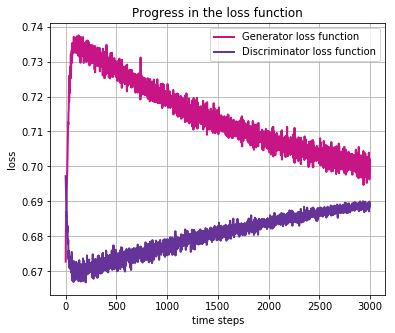

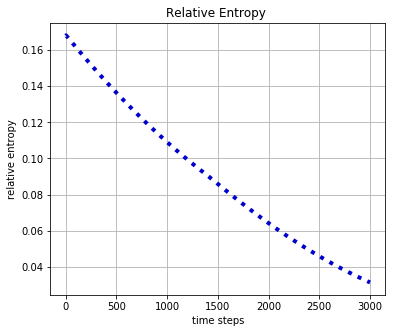

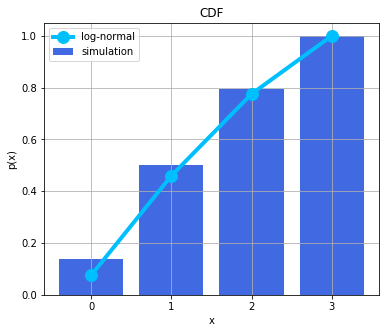

In [5]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_samples(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()